In [ ]:
!pip install dtreeviz
!pip install -Uqq fastbook
import fastbook

from fastbook import *
from fastai.tabular.all import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

In [ ]:
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv', low_memory=False)
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv', low_memory=False)
submission = pd.read_csv('../input/bike-sharing-demand/sampleSubmission.csv', low_memory=False)
train.head(1)

In [ ]:
train.tail(1)

Training spans from the 1st day of each month to the 19th. The test set begins on the 20th to the end of the month.

In [ ]:
len(train.columns), len(test.columns)

In [ ]:
train.columns

In [ ]:
test.columns

### Column Metadata

1. `datetime`: hourly date + timestamp  

1. `season`:  
    - `1` = spring 
    - `2` = summer
    - `3` = fall
    - `4` = winter 

1. `holiday`: whether the day is considered a holiday

1. `workingday`: whether the day is neither a weekend nor holiday

1. `weather`:
    - `1`: Clear, Few clouds, Partly cloudy, Partly cloudy
    - `2`: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - `3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - `4`: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


1. `temp`: temperature in Celsius

1. `atemp`: "feels like" temperature in Celsius

1. `humidity`: relative humidity

1. `windspeed`: wind speed

1. `casual`: number of non-registered user rentals initiated

1. `registered`: number of registered user rentals initiated

1. `count`: number of total rentals


The columns below seem to be the only categorical columns, all having less than 4 discrete levels.

In [ ]:
train.season.unique(), train.holiday.unique(), train.weather.unique(), train.workingday.unique()

All data types seem to fit well into their descriptions except for `datetime` which needs to be converted into a `pd.Datetime` object.

In [ ]:
train.dtypes

The number of bikes at the station is what needs to be predicted, this is represented as the `count` column and is the dependent variable. The dataset specifies to use the RMSLE (Root Mean Squared Log Error) as the loss function.

In [ ]:
dep_var = 'count'
train[dep_var] = np.log(train[dep_var])
# test[dep_var] = np.log(test[dep_var])

## Decision Trees
Decision trees perfrom well with structured data like this dataset so it seems the obvious approach. It relies on a series of binary questions that tree asks to exclude certain possibilities, as we descend the tree the questions get more specific to narrow the prediction, similar to a game of 20 questions.

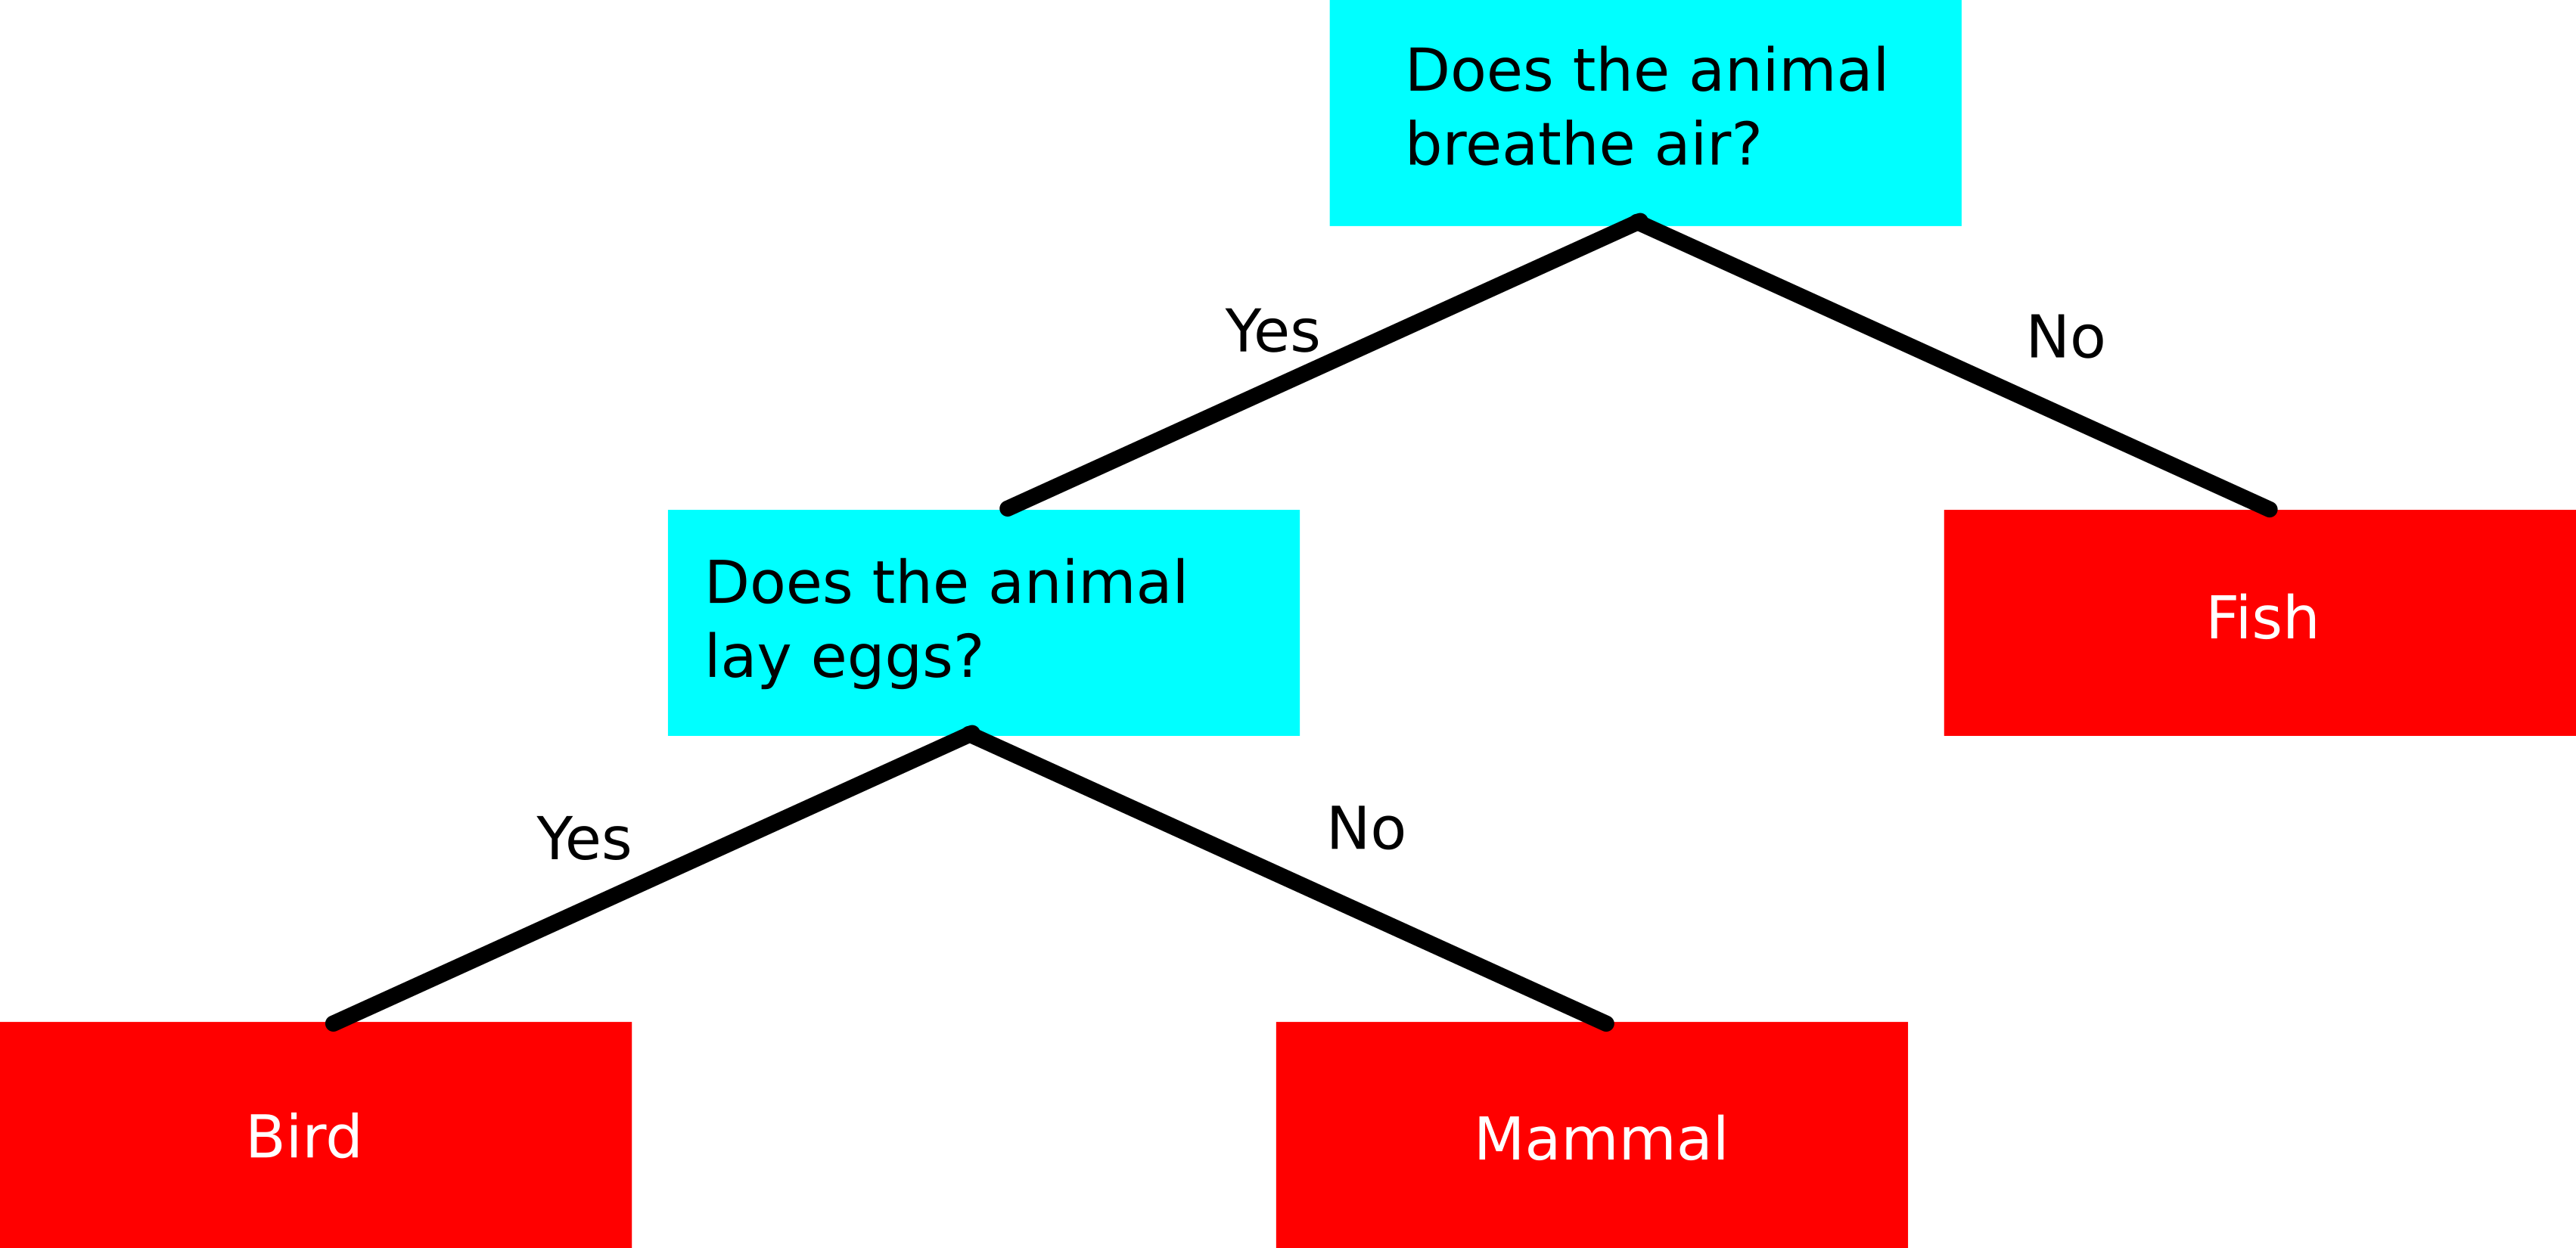

### Date Parsing
Dates are unlike most data types as they can seen as both continuous and categorical variables. Each date can be categorised into weekday/weekend or holiday/non-holiday and at the same time we can use the day of the month as a number. This gives dates the bonus of being able to create more data from data.
- ordinality


Dates are usually a hassle to work with but, FastAI comes with a nifty function that does a lot of the date parsing for us.

In [ ]:
train = add_datepart(train, 'datetime')
test = add_datepart(test, 'datetime')

In [ ]:
train.columns

The `add_datepart` function has created additional date columns. Prining out all unique values of the datepart shows a combination if continuous and categorical variables.

In [ ]:
for i in train.columns[train.columns.str.contains('datetime')]:
    print('\n'+i+': '+str(train[i].unique()))

In [ ]:
len(train.columns), len(test.columns)

### TabularPandas & TabularProcs
`TabularPandas` provides a wrapper around a standard Pandas DataFrame to help with missing values. To use `TabularPandas`, `TabularProcs` must be use to tell FastAI how to handle the missing values, the ones used here are `Categorify` and `FillMissing`.

`Categorify`: replace a column with a categorical one

`FillMissing`: replaces missing values with the median of that column


`TabularPandas` also handle the splitting of the training and validation sets, because this a time series prediction where the goal is to know how many bikes will be a at a station in the future, the validation set must be the latter portion of the set as we need this to verify the predictions.

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
train.columns[train.columns.str.contains('datetime', case=False)]

In [ ]:
# train.drop(columns=['casual', 'registered'], inplace=True)

In [ ]:
len(train.columns), len(test.columns)

The choice of split below was not terribly scientific; I roughly split the set into a 60:40 split in favour of training set.

In [ ]:
cond = (train.datetimeYear<2011) | (train.datetimeMonth<8)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))
'training: ', len(train_idx), 'validation: ', len(valid_idx)

The function below splits the continuous and categorical columns for `TabularPandas` to understand.

In [ ]:
cont,cat = cont_cat_split(train, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(train, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
dls.show_batch()

### Creating Decision Tree

`xs` denotes the independent variable and `y` the dependent.

In [ ]:
xs, y = to.train.xs, to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
model = DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(xs, y);

The visualisation below shows what factors that cause a split and gives a better insight into what is actually happening.

In [ ]:
draw_tree(model, xs, size=10, leaves_parallel=True, precision=2)

This plot shows the data distribution of each split. This can help in finding outliers in the data that may be skewing the predictions. The top node is the model's state before any data splits have been made. This node will predict the average of the whole set.

In [ ]:
idx = np.random.permutation(len(y))[:500]
dtreeviz(model, xs.iloc[idx], y.iloc[idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

- write on this

In [ ]:
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

## Random Forests

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=4507,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
# model = rf(xs, y);
# m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y)
model = tabular_learner(dls, metrics=accuracy)

In [ ]:
model.fit_one_cycle(1)

In [ ]:
model.show_results()

### Submission

In [ ]:
test.columns

In [ ]:
train.columns

In [ ]:
test_df = train.copy()
test_df.drop(['count'], axis=1, inplace=True)
dl = model.dls.test_dl(test_df)

In [ ]:
preds = model.get_preds(dl=dl)

In [ ]:
# randomforest_preds = model.predict(test)

In [ ]:
preds[0][:6492]

In [ ]:
preds_l = [float(i) for i in preds[0]]
preds_l

In [ ]:
submission['count'] = np.exp(preds_l[:6493])
submission.to_csv('submission.csv', index=False)